In [1]:
import torch
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from hydra import initialize, compose
from hydra.utils import instantiate
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog
from case_studies.dc2_mdt.utils.rml_encoder import DC2MDTRMLEncoder

In [2]:
model_name = "exp_06-08-1"
model_check_point_name = "encoder_82.ckpt"
model_path = f"../../../bliss_output/DC2_flux_only_rml_exp/{model_name}/checkpoints/{model_check_point_name}"
cached_data_path = Path("/data/scratch/pduan/posterior_cached_files")
device = torch.device("cuda:3")
with initialize(config_path="./mdt_config", version_base=None):
    cfg = compose("flux_only_mdt_rml_train_config")

In [3]:
seed = cfg.train.seed
pytorch_lightning.seed_everything(seed=seed)

Seed set to 7272


7272

In [4]:
batch_size = 800
dc2: DC2DataModule = instantiate(cfg.surveys.dc2)
dc2.batch_size = batch_size
dc2.setup(stage="validate")
dc2_val_dataloader = dc2.val_dataloader()

In [5]:
my_encoder: DC2MDTRMLEncoder = instantiate(cfg.encoder).to(device=device)
pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
my_encoder.load_state_dict(pretrained_weights)
my_encoder.eval();

In [6]:
cached_file_name = "flux_only_rml_posterior_" \
                    f"{model_name}_{model_check_point_name}_" \
                    f"seed_{seed}.pt"
save_path = cached_data_path / cached_file_name

In [7]:
if not os.path.isfile(save_path):
    print("can't find cached file; rerun the inference")
    target_images = []
    target_n_sources = []
    target_locs = []
    target_fluxes = []
    n_sources_list = []
    locs_list = []
    fluxes_list = []
    for one_batch in tqdm.tqdm(dc2_val_dataloader):
        one_batch = move_data_to_device(one_batch, device=device)
        target_tile_cat = TileCatalog(one_batch["tile_catalog"]).get_brightest_sources_per_tile()
        target_images.append(one_batch["images"].cpu())
        target_n_sources.append(target_tile_cat["n_sources"].cpu())
        target_locs.append(target_tile_cat["locs"].cpu())
        target_fluxes.append(target_tile_cat["fluxes"].cpu())
        
        with torch.no_grad():
            sample_tile_cat = my_encoder.sample(one_batch)
        cur_n_sources = sample_tile_cat["n_sources"]
        n_sources_list.append(cur_n_sources.cpu())
        locs_list.append(sample_tile_cat["locs"].cpu())  # (b, h, w, m, 2)
        fluxes_list.append(sample_tile_cat["fluxes"].cpu())  # (b, h, w, m, 6)

    rml_result_dict = {
        "n_sources_list": n_sources_list,
        "locs_list": locs_list,
        "fluxes_list": fluxes_list,
        "target_images": target_images,
        "target_n_sources": target_n_sources,
        "target_locs": target_locs,
        "target_fluxes": target_fluxes,
    }
    torch.save(rml_result_dict, save_path)
else:
    print("find the cached file; run nothing")
    with open(save_path, "rb") as f:
        rml_result_dict = torch.load(f, map_location="cpu")

can't find cached file; rerun the inference


100%|██████████| 32/32 [04:23<00:00,  8.25s/it]


In [8]:
target_locs[0].shape

torch.Size([800, 20, 20, 1, 2])

In [9]:
target_fluxes[0].shape

torch.Size([800, 20, 20, 1, 6])

In [10]:
rml_result_dict["fluxes_list"][0].shape

torch.Size([800, 20, 20, 1, 6])

In [11]:
def get_in_boundary_mask(locs, n_sources, boundary_width, pad_width):
    def get_index_map(mask: torch.Tensor, dim, shift):
        assert mask.ndim == 3
        assert shift == -1 or shift == 1
        assert dim == 1 or dim == 2
        m_index = mask.nonzero()  # (z, 3)
        m_index_shift = m_index.clone()
        m_index_shift[:, dim] += shift
        return torch.stack([m_index, m_index_shift], dim=-2)  # (z, 2, 3)
    
    assert locs.ndim == 4
    
    top_in_boundary = (locs[..., 0] > (1.0 - boundary_width)) & \
                      (locs[..., 1] > pad_width) & \
                      (locs[..., 1] < (1.0 - pad_width)) & \
                      (n_sources > 0)  # (b, h, w)
    top_in_boundary[:, -1, :] = False
    top_in_boundary_index_map = get_index_map(top_in_boundary, dim=1, shift=1)

    bottom_in_boundary = (locs[..., 0] < boundary_width) & \
                      (locs[..., 1] > pad_width) & \
                      (locs[..., 1] < (1.0 - pad_width)) & \
                      (n_sources > 0)
    bottom_in_boundary[:, 0, :] = False
    bottom_in_boundary_index_map = get_index_map(bottom_in_boundary, dim=1, shift=-1)
    

    left_in_boundary = (locs[..., 1] < boundary_width) & \
                      (locs[..., 0] > pad_width) & \
                      (locs[..., 0] < (1.0 - pad_width)) & \
                      (n_sources > 0)
    left_in_boundary[:, :, 0] = False
    left_in_boundary_index_map = get_index_map(left_in_boundary, dim=2, shift=-1)

    right_in_boundary = (locs[..., 1] > (1.0 - boundary_width)) & \
                        (locs[..., 0] > pad_width) & \
                        (locs[..., 0] < (1.0 - pad_width)) & \
                        (n_sources > 0)
    right_in_boundary[:, :, -1] = False
    right_in_boundary_index_map = get_index_map(right_in_boundary, dim=2, shift=1)

    return {
        "top_in_boundary_index_map": top_in_boundary_index_map,
        "bottom_in_boundary_index_map": bottom_in_boundary_index_map,
        "left_in_boundary_index_map": left_in_boundary_index_map,
        "right_in_boundary_index_map": right_in_boundary_index_map,
    }

In [12]:
target_in_boundary_fluxes = []
pred_in_boundary_fluxes = []
for t_n_sources, t_locs, t_fluxes, pred_fluxes in zip(rml_result_dict["target_n_sources"],
                                                      rml_result_dict["target_locs"],
                                                      rml_result_dict["target_fluxes"],
                                                      rml_result_dict["fluxes_list"],
                                                      strict=True):
    boundary_ip = get_in_boundary_mask(locs=t_locs.squeeze(-2),
                                       n_sources=t_n_sources,
                                       boundary_width=0.02,
                                       pad_width=0.2)
    t_in_b_fluxes = []
    pred_in_b_fluxes = []
    for v in boundary_ip.values():
        for sub_v in v:
            t_in_b_fluxes.append(t_fluxes[sub_v[:, 0], sub_v[:, 1], sub_v[:, 2], 0, :])
            pred_in_b_fluxes.append(pred_fluxes[sub_v[:, 0], sub_v[:, 1], sub_v[:, 2], 0, :])
    target_in_boundary_fluxes.append(torch.stack(t_in_b_fluxes, dim=0))
    pred_in_boundary_fluxes.append(torch.stack(pred_in_b_fluxes, dim=0))
target_in_boundary_fluxes = torch.cat(target_in_boundary_fluxes, dim=0)
pred_in_boundary_fluxes = torch.cat(pred_in_boundary_fluxes, dim=0)

In [13]:
target_in_boundary_fluxes.shape, pred_in_boundary_fluxes.shape

(torch.Size([7169, 2, 6]), torch.Size([7169, 2, 6]))

In [14]:
shuffle_fluxes = lambda x: x[torch.randperm(x.shape[0]), :]
shuffle_fluxes = torch.vmap(shuffle_fluxes, randomness="different")

In [15]:
target_in_boundary_fluxes = shuffle_fluxes(target_in_boundary_fluxes)

In [16]:
def draw_boundary_fluxes_scatter_plot(boundary_fluxes, first_n_elements, suptitle):
    assert (boundary_fluxes >= 0.0).all()
    x = boundary_fluxes[:, 0, :]
    y = boundary_fluxes[:, 1, :]
    if first_n_elements is not None:
        selected_indexes = torch.randperm(x.shape[0])[:first_n_elements]
        x = x[selected_indexes]
        y = y[selected_indexes]
    x = torch.log1p(x.T)  # (bands, n)
    y = torch.log1p(y.T) 
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), constrained_layout=True)
    for sub_x, sub_y, ax, band_name in zip(x, y, axes.flatten(), "ugrizy", strict=True):
        ax.scatter(sub_x, sub_y, s=20, alpha=0.5, 
                   edgecolors="none")
        ax.set_xlabel("log1p(Flux 1)")
        ax.set_ylabel("log1p(Flux 2)")
        ax.set_title(f"Band: {band_name}")
    fig.suptitle(suptitle)
    fig.show()

In [17]:
def draw_boundary_fluxes_kde_plot(boundary_fluxes, first_n_elements, suptitle):
    assert (boundary_fluxes >= 0.0).all()
    x = boundary_fluxes[:, 0, :]
    y = boundary_fluxes[:, 1, :]
    if first_n_elements is not None:
        selected_indexes = torch.randperm(x.shape[0])[:first_n_elements]
        x = x[selected_indexes]
        y = y[selected_indexes]
    x = torch.log1p(x.T)  # (bands, n)
    y = torch.log1p(y.T) 
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), constrained_layout=True)
    for sub_x, sub_y, ax, band_name in zip(x, y, axes.flatten(), "ugrizy", strict=True):
        sns.kdeplot(
            x=sub_x, y=sub_y,
            fill=True,
            levels=30,
            thresh=0.0,
            cmap="viridis",
            ax=ax
        )
        sns.kdeplot(
            x=sub_x, y=sub_y,
            fill=False,
            levels=5,
            color="red",
            linewidths=1.0,
            thresh=1e-1,
            ax=ax
        )
        ax.set_xlabel("log1p(Flux 1)")
        ax.set_ylabel("log1p(Flux 2)")
        ax.set_title(f"Band: {band_name}")
    fig.suptitle(suptitle)
    fig.show()

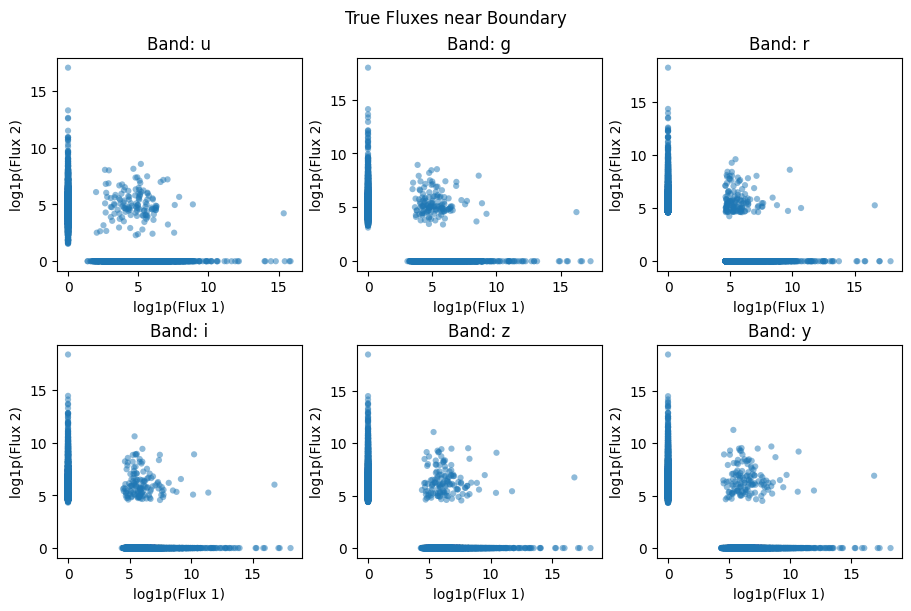

In [18]:
draw_boundary_fluxes_scatter_plot(target_in_boundary_fluxes, 
                                  first_n_elements=None, 
                                  suptitle="True Fluxes near Boundary")

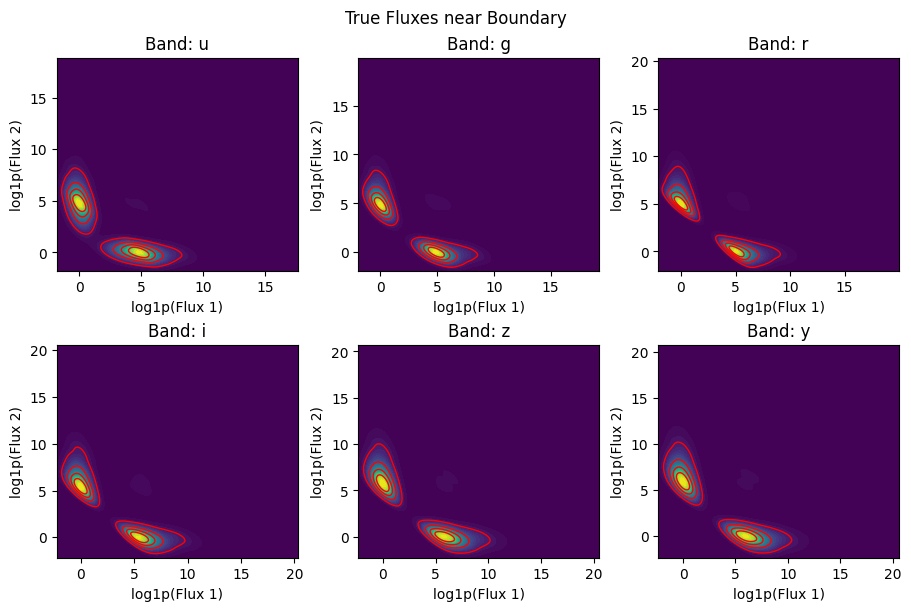

In [19]:
draw_boundary_fluxes_kde_plot(target_in_boundary_fluxes,
                              first_n_elements=None,
                              suptitle="True Fluxes near Boundary")

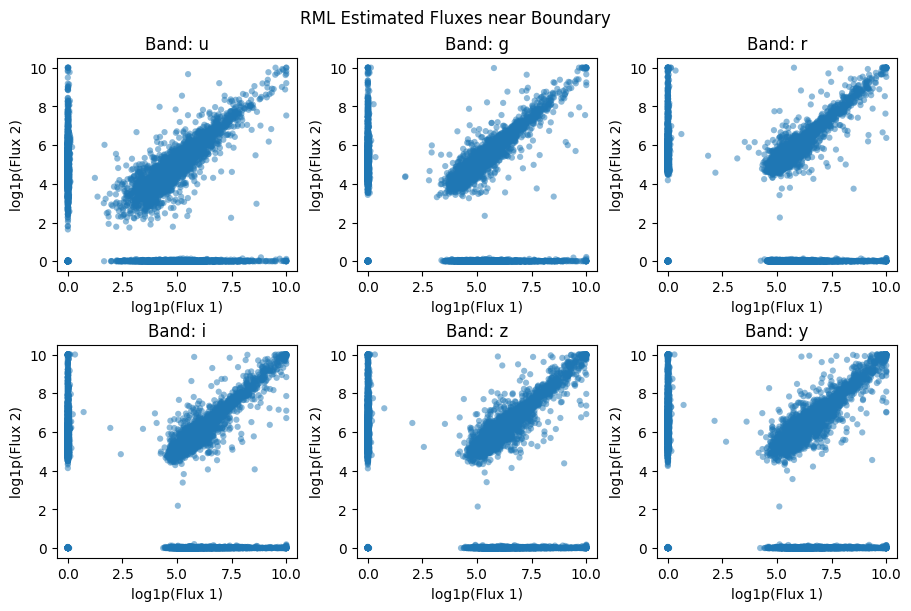

In [20]:
draw_boundary_fluxes_scatter_plot(pred_in_boundary_fluxes, 
                                  first_n_elements=None, 
                                  suptitle="RML Estimated Fluxes near Boundary")

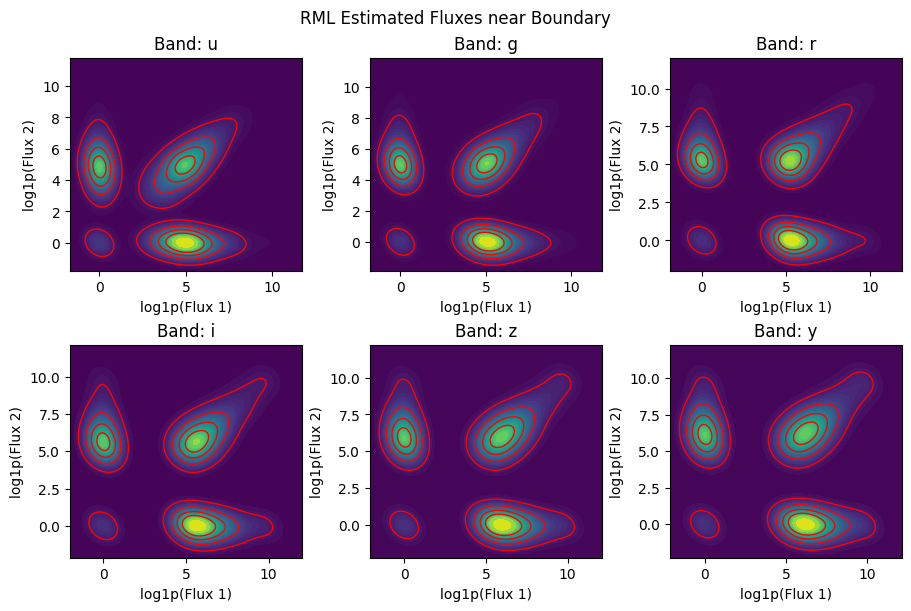

In [21]:
draw_boundary_fluxes_kde_plot(pred_in_boundary_fluxes,
                              first_n_elements=None,
                              suptitle="RML Estimated Fluxes near Boundary")